# normal_model

## time pyd_data

## 原始数据读取

In [58]:
import pandas as pd
import numpy as np

# ===================== 1️⃣ 路径 =====================
cwt_train_csv = "/home/charles/HZU/Data_processed/HSML/MCC5/train/train_CWT_main.csv"
cwt_val_csv   = "/home/charles/HZU/Data_processed/HSML/MCC5/val/val_CWT_main.csv"
cwt_test_csv  = "/home/charles/HZU/Data_processed/HSML/MCC5/test/test_CWT_main.csv"

# aux_train_csv = "/home/charles/HZU/Data_processed/HSML/MCC5/train/train_aux.csv"
# aux_val_csv   = "/home/charles/HZU/Data_processed/HSML/MCC5/val/val_aux.csv"
# aux_test_csv  = "/home/charles/HZU/Data_processed/HSML/MCC5/test/test_aux.csv"
aux_train_csv = "/home/charles/HZU/Data_processed/HSML/MCC5/train/train_CWT_aux.csv"
aux_val_csv   = "/home/charles/HZU/Data_processed/HSML/MCC5/val/val_CWT_aux.csv"
aux_test_csv  = "/home/charles/HZU/Data_processed/HSML/MCC5/test/test_CWT_aux.csv"
# ===================== 2️⃣ 参数（必须与 CWT 一致） =====================
WINDOW = 512

AUX_FEATURES = [
    "speed",
    "torque",
    "gearbox_vibration_x",
    "gearbox_vibration_y",
    "gearbox_vibration_z",
]

LABEL_COL = "class_id"

# ===================== 3️⃣ 对齐函数 =====================
def align_aux_with_cwt(cwt_df, aux_df):

    aligned_rows = []
    labels = []

    for i, row in cwt_df.iterrows():
        start = int(row["window_start"])
        end   = start + WINDOW

        aux_chunk = aux_df.iloc[start:end]

        # ---- 安全检查 ----
        if len(aux_chunk) != WINDOW:
            raise ValueError(f"Aux window length mismatch at window_start={start}")

        feat = aux_chunk[AUX_FEATURES].mean().values
        aligned_rows.append(feat)

        labels.append(row["label"])

    aligned_rows = np.asarray(aligned_rows)

    df_aux_win = pd.DataFrame(
        aligned_rows,
        columns=[f"aux_{c}" for c in AUX_FEATURES]
    )
    df_aux_win["label"] = labels

    return df_aux_win

# ===================== 4️⃣ 读取 =====================
cwt_train_df = pd.read_csv(cwt_train_csv)
cwt_val_df   = pd.read_csv(cwt_val_csv)
cwt_test_df  = pd.read_csv(cwt_test_csv)

aux_train_df = pd.read_csv(aux_train_csv)
aux_val_df   = pd.read_csv(aux_val_csv)
aux_test_df  = pd.read_csv(aux_test_csv)

# # ===================== 5️⃣ 对齐 =====================
# aux_train_win = align_aux_with_cwt(cwt_train_df, aux_train_df)
# aux_val_win   = align_aux_with_cwt(cwt_val_df, aux_val_df)
# aux_test_win  = align_aux_with_cwt(cwt_test_df, aux_test_df)

# # ===================== 6️⃣ 保存 =====================
# aux_train_win.to_csv(
#     "/home/charles/HZU/Data_processed/HSML/MCC5/train/train_aux_aligned.csv",
#     index=False
# )
# aux_val_win.to_csv(
#     "/home/charles/HZU/Data_processed/HSML/MCC5/val/val_aux_aligned.csv",
#     index=False
# )
# aux_test_win.to_csv(
#     "/home/charles/HZU/Data_processed/HSML/MCC5/test/test_aux_aligned.csv",
#     index=False
# )

# print("✅ 主模态 CWT 与辅助模态 已完成 window-level 对齐")


## 六个集图结构搭建

In [59]:
# ===================== 单cell：CWT & AUX 列归一化 -> 多数据集构图并保存 =====================
import os
import numpy as np
import pandas as pd
import torch

# --------------------- 输出目录 ---------------------
out_root = "/home/charles/HZU/Data_processed/HSML/MCC5"
os.makedirs(out_root, exist_ok=True)

# --------------------- 输入路径 ---------------------
mcc5_root = "/home/charles/HZU/Data_processed/HSML/MCC5"

paths = {
    # -------- 主模态（CWT）--------
    "cwt_train": f"{mcc5_root}/train/train_CWT_main.csv",
    "cwt_val":   f"{mcc5_root}/val/val_CWT_main.csv",
    "cwt_test":  f"{mcc5_root}/test/test_CWT_main.csv",

    # -------- 辅助模态（window-level，对齐后）--------
    "aux_train": f"{mcc5_root}/train/train_CWT_aux.csv",
    "aux_val":   f"{mcc5_root}/val/val_CWT_aux.csv",
    "aux_test":  f"{mcc5_root}/test/test_CWT_aux.csv",
}

# --------------------- 图参数 ---------------------
k = 10
tau = 2.0
eps = 1e-6

def weight_from_dist(dist):
    return np.exp(-dist / tau).astype(np.float32)

def build_temporal_k_graph(num_nodes, k):
    k_up = k // 2
    k_dn = k - k_up

    src, dst, dist = [], [], []

    for i in range(num_nodes):
        for d in range(1, k_up + 1):
            j = i - d
            if j < 0: break
            src.append(i); dst.append(j); dist.append(d)

        for d in range(1, k_dn + 1):
            j = i + d
            if j >= num_nodes: break
            src.append(i); dst.append(j); dist.append(d)

    src = np.array(src, dtype=np.int64)
    dst = np.array(dst, dtype=np.int64)
    dist = np.array(dist, dtype=np.float32)

    w = weight_from_dist(dist)

    edge_index = torch.tensor(
        np.stack([np.concatenate([src, dst]), np.concatenate([dst, src])], axis=0),
        dtype=torch.long
    )
    edge_weight = torch.tensor(np.concatenate([w, w]), dtype=torch.float32)

    return edge_index, edge_weight

# --------------------- 主流程 ---------------------
for name, csv_path in paths.items():
    print(f"\n=== Processing {name} ===")
    df = pd.read_csv(csv_path)

    # 1️⃣ 特征 / 标签分离
    X_df = df.iloc[:, :-1].copy()
    y_df = df.iloc[:, -1].copy()

    # 2️⃣ 删除 NaN 列（AUX 有概率出现，统一处理）
    nan_cols = X_df.columns[X_df.isna().any(axis=0)]
    X_df = X_df.drop(columns=nan_cols)
    if len(nan_cols) > 0:
        print(f"Removed NaN columns: {len(nan_cols)}")

    # 3️⃣ 列归一化（Z-score，按数据集各自统计）
    col_mean = X_df.mean(axis=0)
    col_std  = X_df.std(axis=0)
    X_df = (X_df - col_mean) / (col_std + eps)

    print("Feature-wise normalization applied")

    X = torch.tensor(X_df.values, dtype=torch.float32)
    y = torch.tensor(y_df.values, dtype=torch.long)

    print(f"X shape: {tuple(X.shape)}, y shape: {tuple(y.shape)}")

    # 4️⃣ 构图（时间邻域）
    edge_index, edge_weight = build_temporal_k_graph(X.shape[0], k)
    print(f"Graph edges: {edge_index.shape[1]}")

    # 5️⃣ 保存
    save_dict = {
        "x": X,
        "y": y,
        "edge_index": edge_index,
        "edge_weight": edge_weight,
    }

    save_path = os.path.join(out_root, f"{name}_graph.pt")
    torch.save(save_dict, save_path)
    print(f"Saved to: {save_path}")

print("\n✅ 主模态 CWT + 辅助模态 AUX 的图结构已全部构建并保存")



=== Processing cwt_train ===
Feature-wise normalization applied
X shape: (2342, 94), y shape: (2342,)
Graph edges: 46780
Saved to: /home/charles/HZU/Data_processed/HSML/MCC5/cwt_train_graph.pt

=== Processing cwt_val ===
Feature-wise normalization applied
X shape: (389, 94), y shape: (389,)
Graph edges: 7720
Saved to: /home/charles/HZU/Data_processed/HSML/MCC5/cwt_val_graph.pt

=== Processing cwt_test ===
Feature-wise normalization applied
X shape: (1170, 94), y shape: (1170,)
Graph edges: 23340
Saved to: /home/charles/HZU/Data_processed/HSML/MCC5/cwt_test_graph.pt

=== Processing aux_train ===
Feature-wise normalization applied
X shape: (2342, 96), y shape: (2342,)
Graph edges: 46780
Saved to: /home/charles/HZU/Data_processed/HSML/MCC5/aux_train_graph.pt

=== Processing aux_val ===
Feature-wise normalization applied
X shape: (389, 96), y shape: (389,)
Graph edges: 7720
Saved to: /home/charles/HZU/Data_processed/HSML/MCC5/aux_val_graph.pt

=== Processing aux_test ===
Feature-wise norm

## 数据打包

In [60]:
# ===================== 单cell：MMFD 六个图数据打包为 PyG DataLoader =====================
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import os

# --------------------- 1️⃣ MMFD 图文件路径 ---------------------
MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/MCC5"

graph_files = {
    # -------- 主模态：CWT --------
    "cwt_train": f"{MMFD_ROOT}/cwt_train_graph.pt",
    "cwt_val":   f"{MMFD_ROOT}/cwt_val_graph.pt",
    "cwt_test":  f"{MMFD_ROOT}/cwt_test_graph.pt",

    # -------- 辅助模态：AUX --------
    "aux_train": f"{MMFD_ROOT}/aux_train_graph.pt",
    "aux_val":   f"{MMFD_ROOT}/aux_val_graph.pt",
    "aux_test":  f"{MMFD_ROOT}/aux_test_graph.pt",
}

# --------------------- 2️⃣ 加载 .pt → PyG Data ---------------------
def load_graph_as_pyg_data(pt_path):
    assert os.path.exists(pt_path), f"File not found: {pt_path}"
    obj = torch.load(pt_path, map_location="cpu")

    data = Data(
        x=obj["x"],
        edge_index=obj["edge_index"],
        y=obj["y"]
    )

    # 如果有 edge_weight，作为 edge_attr
    if "edge_weight" in obj and obj["edge_weight"] is not None:
        data.edge_attr = obj["edge_weight"].unsqueeze(-1)

    return data


data_dict = {}
for name, path in graph_files.items():
    data = load_graph_as_pyg_data(path)
    data_dict[name] = data
    print(
        f"[Loaded] {name}: "
        f"x={tuple(data.x.shape)}, "
        f"edges={data.edge_index.shape[1]}"
    )

# --------------------- 3️⃣ 构造 DataLoader（batch_size=1，整图训练） ---------------------
def build_loader(data, shuffle=True):
    return DataLoader([data], batch_size=1, shuffle=shuffle)

# -------- 主模态 CWT --------
cwt_loader      = build_loader(data_dict["cwt_train"], shuffle=True)
cwt_val_loader  = build_loader(data_dict["cwt_val"],   shuffle=False)
cwt_test_loader = build_loader(data_dict["cwt_test"],  shuffle=False)

# -------- 辅助模态 AUX --------
aux_loader      = build_loader(data_dict["aux_train"], shuffle=True)
aux_val_loader  = build_loader(data_dict["aux_val"],   shuffle=False)
aux_test_loader = build_loader(data_dict["aux_test"],  shuffle=False)

print("\n✅ MMFD 主模态（CWT）+ 辅助模态（AUX）图数据已全部打包为 PyG DataLoader")


[Loaded] cwt_train: x=(2342, 94), edges=46780
[Loaded] cwt_val: x=(389, 94), edges=7720
[Loaded] cwt_test: x=(1170, 94), edges=23340
[Loaded] aux_train: x=(2342, 96), edges=46780
[Loaded] aux_val: x=(389, 96), edges=7720
[Loaded] aux_test: x=(1170, 96), edges=23340

✅ MMFD 主模态（CWT）+ 辅助模态（AUX）图数据已全部打包为 PyG DataLoader


/tmp/ipykernel_231681/2162965824.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pt_path, map_location="cpu")


# GCL模型

## 模型初始化

In [61]:
# ===================== 单cell：为主模态（CWT）与辅助模态（AUX）定义两个独立的 GCL 模型 =====================
import sys
import torch

# --------------------- 1️⃣ 导入 models.py ---------------------
MODEL_DIR = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/src"
sys.path.append(MODEL_DIR)

from models import GraphContrastiveLearner

print("✅ models.py imported")

# --------------------- 2️⃣ 设备 ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------- 3️⃣ 从已保存图中读取特征维度 ---------------------

# ===== CWT 主模态 =====
cwt_graph = torch.load(
    "/home/charles/HZU/Data_processed/HSML/MCC5/cwt_train_graph.pt",
    map_location="cpu"
)
cwt_in_dim = cwt_graph["x"].shape[1]
print(f"CWT feature dim: {cwt_in_dim}")

# ===== AUX 辅助模态 =====
aux_graph = torch.load(
    "/home/charles/HZU/Data_processed/HSML/MCC5/aux_train_graph.pt",
    map_location="cpu"
)
aux_in_dim = aux_graph["x"].shape[1]
print(f"AUX feature dim: {aux_in_dim}")

# --------------------- 4️⃣ 定义两个独立的 GCL 模型 ---------------------

# ===== 主模态：CWT =====
gcl_cwt = GraphContrastiveLearner(
    in_dim=cwt_in_dim,
    hidden_dim=256*2,   # 主模态容量大
    out_dim=128*2,
    proj_dim=128*2,
    tau=0.5
).to(device)

# ===== 辅助模态：AUX =====
gcl_aux = GraphContrastiveLearner(
    in_dim=aux_in_dim,
    hidden_dim=256*2,   # 辅助模态不必太宽
    out_dim=128*2,
    proj_dim=128*2,
    tau=0.5
).to(device)

# --------------------- 5️⃣ 打印确认 ---------------------
print("\n✅ Two independent GCL models initialized")

print("\nGCL_CWT:\n", gcl_cwt)
print("\nGCL_AUX:\n", gcl_aux)


✅ models.py imported
Using device: cuda
CWT feature dim: 94
AUX feature dim: 96

✅ Two independent GCL models initialized

GCL_CWT:
 GraphContrastiveLearner(
  (encoder): GCNEncoder(
    (conv1): SAGEConv(94, 512, aggr=mean)
    (conv2): SAGEConv(512, 256, aggr=mean)
  )
  (projector): MLPHead(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=256, out_features=256, bias=True)
  )
)

GCL_AUX:
 GraphContrastiveLearner(
  (encoder): GCNEncoder(
    (conv1): SAGEConv(96, 512, aggr=mean)
    (conv2): SAGEConv(512, 256, aggr=mean)
  )
  (projector): MLPHead(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=256, out_features=256, bias=True)
  )
)


/tmp/ipykernel_231681/4007275269.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_graph = torch.load(
/tmp/ipykernel_231681/4007275269.py:28: FutureWarning: You are 

## 训练

In [62]:
# ===================== 单cell：CWT / AUX 双模态 GCL 预训练（统一保存路径） =====================
import os
import torch

# ======================================================
# 0️⃣ 基本准备
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
weight_decay = 1e-5

print("Using device:", device)

# ======================================================
# 1️⃣ GCL 模型保存根目录（你指定的路径）
# ======================================================
GCL_SAVE_ROOT = (
    "/home/charles/HZU/Industrial_Software_Testing/"
    "Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/"
    "model_save/time_CWT/MMFD/double_m/GCL"
)
os.makedirs(GCL_SAVE_ROOT, exist_ok=True)

# ======================================================
# 2️⃣ 学习率 & Optimizer（按模态区分）
# ======================================================
lr_cwt = 1e-3      # 主模态（CWT）
lr_aux = 2e-3      # 辅助模态（AUX）

optimizer_cwt = torch.optim.Adam(
    gcl_cwt.parameters(),
    lr=lr_cwt,
    weight_decay=weight_decay
)

optimizer_aux = torch.optim.Adam(
    gcl_aux.parameters(),
    lr=lr_aux,
    weight_decay=weight_decay
)

print("✅ Optimizers initialized")
print(f"optimizer_cwt: lr={lr_cwt}, weight_decay={weight_decay}")
print(f"optimizer_aux: lr={lr_aux}, weight_decay={weight_decay}")

# ======================================================
# 3️⃣ 数据增强函数（来自 models.py）
# ======================================================
from models import augment_graph

# ======================================================
# 4️⃣ 通用 GCL 训练函数（整图 / batch_size=1）
# ======================================================
def train_gcl_single_modal(
    model,
    loader,
    optimizer,
    save_dir,
    model_name
):
    os.makedirs(save_dir, exist_ok=True)

    # ===== 从模型中自动读取真实结构 =====
    with torch.no_grad():
        # encoder
        in_dim = model.encoder.conv1.in_channels
        hidden_dim = model.encoder.conv1.out_channels
        out_dim = model.encoder.conv2.out_channels

        # projector
        proj_dim = model.projector.fc2.out_features

        # temperature
        tau = float(model.tau)

    print(
        f"[{model_name}] Auto config | "
        f"in={in_dim}, hidden={hidden_dim}, out={out_dim}, proj={proj_dim}, tau={tau}"
    )

    best_loss = float("inf")
    best_model_path = os.path.join(save_dir, f"{model_name}_best.pt")

    print(f"\n================= 🚀 开始 {model_name} GCL 预训练 =================\n")

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for batch_data in loader:
            data = batch_data[0].to(device)

            data1 = augment_graph(
                data,
                feature_drop_prob=0.2,
                edge_drop_prob=0.1,
                noise_std=0.02
            ).to(device)

            data2 = augment_graph(
                data,
                feature_drop_prob=0.2,
                edge_drop_prob=0.1,
                noise_std=0.02
            ).to(device)

            loss = model.compute_loss(
                data1.x, data1.edge_index,
                data2.x, data2.edge_index
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch % 10 == 0:
            print(
                f"[{model_name}] Epoch [{epoch:03d}/{epochs}] | "
                f"InfoNCE Loss: {total_loss:.4f}"
            )

        if total_loss < best_loss:
            best_loss = total_loss
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "best_loss": best_loss,
                    "epoch": epoch,
                    "config": {
                        "in_dim": in_dim,
                        "hidden_dim": hidden_dim,
                        "out_dim": out_dim,
                        "proj_dim": proj_dim,
                        "tau": tau,
                    },
                },
                best_model_path,
            )
            print(f"💾 [{model_name} BEST] Epoch {epoch} | Loss={total_loss:.4f}")

    final_path = os.path.join(save_dir, f"{model_name}_epoch{epochs}.pt")
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "epoch": epochs,
            "config": {
                "in_dim": in_dim,
                "hidden_dim": hidden_dim,
                "out_dim": out_dim,
                "proj_dim": proj_dim,
                "tau": tau,
            },
        },
        final_path,
    )

    print(f"\n🏁 [{model_name}] 最终模型保存至: {final_path}")
    print(f"🏆 [{model_name}] 最优模型保存至: {best_model_path} | best_loss={best_loss:.4f}")


# ======================================================
# 5️⃣ CWT 主模态 GCL 训练
# ======================================================
train_gcl_single_modal(
    model=gcl_cwt,
    loader=cwt_loader,
    optimizer=optimizer_cwt,
    save_dir=os.path.join(GCL_SAVE_ROOT, "CWT"),
    model_name="CWT_GCL",
)

# ======================================================
# 6️⃣ AUX 辅助模态 GCL 训练
# ======================================================
train_gcl_single_modal(
    model=gcl_aux,
    loader=aux_loader,
    optimizer=optimizer_aux,
    save_dir=os.path.join(GCL_SAVE_ROOT, "AUX"),
    model_name="AUX_GCL",
)
print("\n🎉 CWT / AUX 双模态 GCL 预训练完成")


Using device: cuda
✅ Optimizers initialized
optimizer_cwt: lr=0.001, weight_decay=1e-05
optimizer_aux: lr=0.002, weight_decay=1e-05
[CWT_GCL] Auto config | in=94, hidden=512, out=256, proj=256, tau=0.5

================= 🚀 开始 CWT_GCL GCL 预训练 =================

💾 [CWT_GCL BEST] Epoch 1 | Loss=58.1850
💾 [CWT_GCL BEST] Epoch 2 | Loss=58.0924
💾 [CWT_GCL BEST] Epoch 3 | Loss=57.5866
💾 [CWT_GCL BEST] Epoch 4 | Loss=57.4108
💾 [CWT_GCL BEST] Epoch 5 | Loss=57.3040
💾 [CWT_GCL BEST] Epoch 6 | Loss=57.2169
💾 [CWT_GCL BEST] Epoch 7 | Loss=57.1517
💾 [CWT_GCL BEST] Epoch 8 | Loss=57.1084
💾 [CWT_GCL BEST] Epoch 9 | Loss=57.0685
[CWT_GCL] Epoch [010/200] | InfoNCE Loss: 57.0312
💾 [CWT_GCL BEST] Epoch 10 | Loss=57.0312
💾 [CWT_GCL BEST] Epoch 11 | Loss=56.9984
💾 [CWT_GCL BEST] Epoch 12 | Loss=56.9732
💾 [CWT_GCL BEST] Epoch 13 | Loss=56.9506
💾 [CWT_GCL BEST] Epoch 14 | Loss=56.9273
💾 [CWT_GCL BEST] Epoch 15 | Loss=56.9081
💾 [CWT_GCL BEST] Epoch 16 | Loss=56.8906
💾 [CWT_GCL BEST] Epoch 17 | Loss=56.8706
💾

## 效果可视化

Using device: cuda
CWT graph: torch.Size([2342, 94])
AUX graph: torch.Size([2342, 96])
✅ GCL encoders loaded
CWT embedding: (2342, 256)
AUX embedding: (2342, 256)


/tmp/ipykernel_231681/1275085251.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pt_path, map_location=device)
/tmp/ipykernel_231681/1275085251.py:54: 

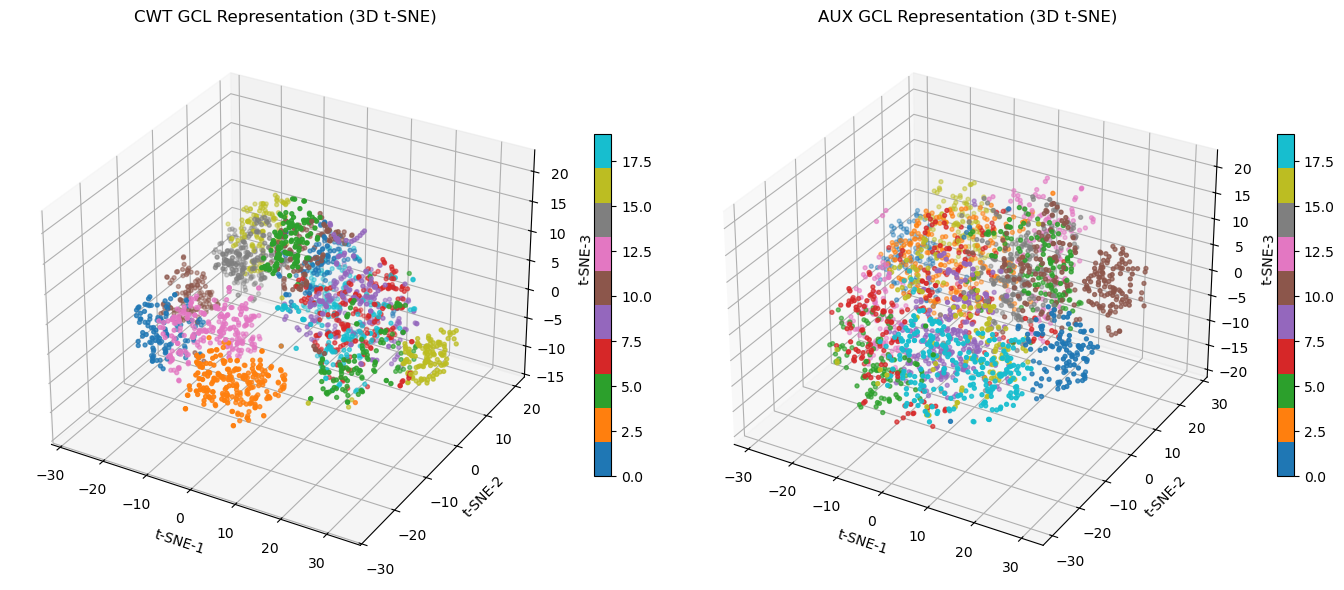

In [63]:
# ===================== 单cell：CWT / AUX 两个模态 GCL 表征 3D 可视化 =====================
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from torch_geometric.data import Data

# ======================================================
# 0️⃣ 设备
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ======================================================
# 1️⃣ 路径配置
# ======================================================
MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/MCC5"

# ---- 图数据 ----
cwt_graph_path = f"{MMFD_ROOT}/cwt_train_graph.pt"
aux_graph_path = f"{MMFD_ROOT}/aux_train_graph.pt"

# ---- GCL 最优模型（你指定的保存目录）----
GCL_SAVE_ROOT = (
    "/home/charles/HZU/Industrial_Software_Testing/"
    "Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/"
    "model_save/time_CWT/MMFD/double_m/GCL"
)

cwt_ckpt = f"{GCL_SAVE_ROOT}/CWT/CWT_GCL_best.pt"
aux_ckpt = f"{GCL_SAVE_ROOT}/AUX/AUX_GCL_best.pt"

# ======================================================
# 2️⃣ 加载图数据
# ======================================================
def load_graph(pt_path):
    obj = torch.load(pt_path, map_location=device)
    return Data(
        x=obj["x"].to(device),
        edge_index=obj["edge_index"].to(device),
        y=obj["y"].to(device)
    )

cwt_data = load_graph(cwt_graph_path)
aux_data = load_graph(aux_graph_path)

print("CWT graph:", cwt_data.x.shape)
print("AUX graph:", aux_data.x.shape)

# ======================================================
# 3️⃣ 加载 GCL encoder（只加载 encoder 权重）
# ======================================================
gcl_cwt.load_state_dict(torch.load(cwt_ckpt, map_location=device)["model_state_dict"])
gcl_aux.load_state_dict(torch.load(aux_ckpt, map_location=device)["model_state_dict"])

gcl_cwt.eval()
gcl_aux.eval()

print("✅ GCL encoders loaded")

# ======================================================
# 4️⃣ 提取表征
# ======================================================
with torch.no_grad():
    h_cwt, _ = gcl_cwt(cwt_data.x, cwt_data.edge_index)
    h_aux, _ = gcl_aux(aux_data.x, aux_data.edge_index)

h_cwt = h_cwt.cpu().numpy()
h_aux = h_aux.cpu().numpy()

y_cwt = cwt_data.y.cpu().numpy()
y_aux = aux_data.y.cpu().numpy()

print("CWT embedding:", h_cwt.shape)
print("AUX embedding:", h_aux.shape)

# ======================================================
# 5️⃣ t-SNE（3D）
# ======================================================
tsne_cwt = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
z_cwt = tsne_cwt.fit_transform(h_cwt)

tsne_aux = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
z_aux = tsne_aux.fit_transform(h_aux)

# ======================================================
# 6️⃣ 3D 可视化
# ======================================================
fig = plt.figure(figsize=(14, 6))

# -------- CWT --------
ax1 = fig.add_subplot(121, projection="3d")
p1 = ax1.scatter(
    z_cwt[:, 0], z_cwt[:, 1], z_cwt[:, 2],
    c=y_cwt, s=8, cmap="tab10"
)
ax1.set_title("CWT GCL Representation (3D t-SNE)")
ax1.set_xlabel("t-SNE-1")
ax1.set_ylabel("t-SNE-2")
ax1.set_zlabel("t-SNE-3")
fig.colorbar(p1, ax=ax1, shrink=0.6)

# -------- AUX --------
ax2 = fig.add_subplot(122, projection="3d")
p2 = ax2.scatter(
    z_aux[:, 0], z_aux[:, 1], z_aux[:, 2],
    c=y_aux, s=8, cmap="tab10"
)
ax2.set_title("AUX GCL Representation (3D t-SNE)")
ax2.set_xlabel("t-SNE-1")
ax2.set_ylabel("t-SNE-2")
ax2.set_zlabel("t-SNE-3")
fig.colorbar(p2, ax=ax2, shrink=0.6)

plt.tight_layout()
plt.show()


## 下游训练 

In [64]:
# ===================== 单cell：定义 train/val/test 的 CWT & AUX 图数据 =====================
import torch
from torch_geometric.data import Data

# --------------------- 设备 ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------- MMFD 根目录 ---------------------
MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/MCC5"

# --------------------- 通用加载函数 ---------------------
def load_mmfd_graph(path):
    obj = torch.load(path, map_location="cpu")
    data = Data(
        x=obj["x"],
        edge_index=obj["edge_index"],
        y=obj["y"]
    )
    # 如果保存了 edge_weight
    if "edge_weight" in obj and obj["edge_weight"] is not None:
        data.edge_attr = obj["edge_weight"].unsqueeze(-1)
    return data

# ======================================================
# 主模态：CWT
# ======================================================
train_data_cwt = load_mmfd_graph(f"{MMFD_ROOT}/cwt_train_graph.pt").to(device)
val_data_cwt   = load_mmfd_graph(f"{MMFD_ROOT}/cwt_val_graph.pt").to(device)
test_data_cwt  = load_mmfd_graph(f"{MMFD_ROOT}/cwt_test_graph.pt").to(device)

# ======================================================
# 辅助模态：AUX
# ======================================================
train_data_aux = load_mmfd_graph(f"{MMFD_ROOT}/aux_train_graph.pt").to(device)
val_data_aux   = load_mmfd_graph(f"{MMFD_ROOT}/aux_val_graph.pt").to(device)
test_data_aux  = load_mmfd_graph(f"{MMFD_ROOT}/aux_test_graph.pt").to(device)

# --------------------- 打印确认 ---------------------
print("\n✅ MMFD Data objects ready")

print("\n[CWT]")
print("Train:", train_data_cwt)
print("Val  :", val_data_cwt)
print("Test :", test_data_cwt)

print("\n[AUX]")
print("Train:", train_data_aux)
print("Val  :", val_data_aux)
print("Test :", test_data_aux)


Using device: cuda

✅ MMFD Data objects ready

[CWT]
Train: Data(x=[2342, 94], edge_index=[2, 46780], y=[2342], edge_attr=[46780, 1])
Val  : Data(x=[389, 94], edge_index=[2, 7720], y=[389], edge_attr=[7720, 1])
Test : Data(x=[1170, 94], edge_index=[2, 23340], y=[1170], edge_attr=[23340, 1])

[AUX]
Train: Data(x=[2342, 96], edge_index=[2, 46780], y=[2342], edge_attr=[46780, 1])
Val  : Data(x=[389, 96], edge_index=[2, 7720], y=[389], edge_attr=[7720, 1])
Test : Data(x=[1170, 96], edge_index=[2, 23340], y=[1170], edge_attr=[23340, 1])


/tmp/ipykernel_231681/1779113821.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(path, map_location="cpu")


In [65]:
# ===================== 单cell：严格类间平衡的 train_withlabel_mask（CWT + AUX） =====================
import torch
import numpy as np

def add_train_withlabel_mask_balanced(
    data,
    label_ratio=0.2,
    seed=42,
    min_per_class=1
):
    """
    严格类间平衡的标注 mask
    - 每个类别使用相同数量的标注样本
    - 标注数由最小类别决定
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    y = data.y.cpu().numpy()
    num_nodes = len(y)

    mask = torch.zeros(num_nodes, dtype=torch.bool)

    classes = np.unique(y)
    class_indices = {c: np.where(y == c)[0] for c in classes}

    # ① 最小类别大小
    min_class_size = min(len(idx) for idx in class_indices.values())

    # ② 每类实际标注数
    num_labeled_per_class = max(
        min_per_class,
        int(min_class_size * label_ratio)
    )

    print(f"📌 Using {num_labeled_per_class} labeled samples per class")

    # ③ 类内均匀随机采样
    for cls, idx in class_indices.items():
        idx = idx.copy()
        np.random.shuffle(idx)
        selected = idx[:num_labeled_per_class]
        mask[selected] = True

    data.train_withlabel_mask = mask.to(data.x.device)
    return data


# ======================================================
# 使用示例（主模态 + 辅助模态）
# ======================================================
label_ratio = 0.2   # 表示“最小类别的 20%”
seed = 42           # 强烈建议固定，保证可复现

# -------- 主模态：CWT --------
train_data_cwt = add_train_withlabel_mask_balanced(
    train_data_cwt,
    label_ratio=label_ratio,
    seed=seed
)

# -------- 辅助模态：AUX --------
train_data_aux = add_train_withlabel_mask_balanced(
    train_data_aux,
    label_ratio=label_ratio,
    seed=seed
)

print("\n✅ Balanced train_withlabel_mask added to CWT & AUX")

# ======================================================
# 自检：每类标注数是否严格一致
# ======================================================
def check_mask_balance(data, name):
    y = data.y
    mask = data.train_withlabel_mask
    print(f"\n[{name}] labeled samples per class:")
    for cls in torch.unique(y):
        cnt = ((y == cls) & mask).sum().item()
        print(f"  class {cls.item():2d}: {cnt}")

check_mask_balance(train_data_cwt, "CWT")
check_mask_balance(train_data_aux, "AUX")


📌 Using 23 labeled samples per class
📌 Using 23 labeled samples per class

✅ Balanced train_withlabel_mask added to CWT & AUX

[CWT] labeled samples per class:
  class  0: 23
  class  1: 23
  class  2: 23
  class  3: 23
  class  4: 23
  class  5: 23
  class  6: 23
  class  7: 23
  class  8: 23
  class  9: 23
  class 10: 23
  class 11: 23
  class 12: 23
  class 13: 23
  class 14: 23
  class 15: 23
  class 16: 23
  class 17: 23
  class 18: 23
  class 19: 23

[AUX] labeled samples per class:
  class  0: 23
  class  1: 23
  class  2: 23
  class  3: 23
  class  4: 23
  class  5: 23
  class  6: 23
  class  7: 23
  class  8: 23
  class  9: 23
  class 10: 23
  class 11: 23
  class 12: 23
  class 13: 23
  class 14: 23
  class 15: 23
  class 16: 23
  class 17: 23
  class 18: 23
  class 19: 23


In [66]:
# ======================================================================
# ⭐ 单 Cell：CWT / AUX 两个 embedding 独立的下游分类训练（含 val 验证）⭐
# ======================================================================
%run ../_init_path.py
from models import DownstreamKANClassifier

import torch
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================================================================
# 0️⃣ 工具函数
# ======================================================================
def l2_normalize(h, eps=1e-8):
    return h / (h.norm(dim=1, keepdim=True) + eps)


def train_downstream_single_modal(
    name,
    gcl_model,
    train_data,
    val_data,
    save_path
):
    print(f"\n================ 🚀 下游分类训练：{name} =================\n")

    # ---- 数据准备 ----
    train_data = train_data.to(device)
    val_data   = val_data.to(device)

    gcl_model = gcl_model.to(device)
    gcl_model.eval()   # 🔒 冻结 encoder

    # ==================================================================
    # 1️⃣ 提取 encoder 表征
    # ==================================================================
    with torch.no_grad():
        h_train, _ = gcl_model(train_data.x, train_data.edge_index)
        h_val,   _ = gcl_model(val_data.x,   val_data.edge_index)

    h_train = l2_normalize(h_train.detach())
    h_val   = l2_normalize(h_val.detach())

    # ---- train labeled subset ----
    y_train = train_data.y
    mask_train = train_data.train_withlabel_mask
    idx_train = mask_train.nonzero(as_tuple=False).view(-1)

    h_train_labeled = h_train[idx_train]
    y_train_labeled = y_train[idx_train]

    # ---- val ----
    y_val = val_data.y

    print(f"📌 [{name}] Train labeled samples: {h_train_labeled.shape[0]}")
    print(f"📌 [{name}] Embedding dim: {h_train_labeled.shape[1]}")

    # ==================================================================
    # 2️⃣ 定义下游分类器（KAN）
    # ==================================================================
    num_features = h_train_labeled.size(1)
    num_classes = int(max(y_train_labeled.max(), y_val.max()).item() + 1)

    classifier = DownstreamKANClassifier(
        in_dim=num_features,
        num_classes=num_classes,
        hidden_dim=128,
        num_knots=4
    ).to(device)

    optimizer = Adam(
        classifier.parameters(),
        lr=1e-3,
        weight_decay=1e-4
    )

    # ==================================================================
    # 3️⃣ 训练 + 验证
    # ==================================================================
    epochs = 500
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, epochs + 1):

        # ---- Train ----
        classifier.train()
        optimizer.zero_grad()

        logits_train = classifier(h_train_labeled)
        loss = F.cross_entropy(logits_train, y_train_labeled)
        loss.backward()
        optimizer.step()

        # ---- Val ----
        classifier.eval()
        with torch.no_grad():
            logits_val = classifier(h_val)
            pred_val = logits_val.argmax(dim=1)
            acc_val = (pred_val == y_val).float().mean().item()

        if epoch % 5 == 0:
            print(
                f"[{name}] Epoch {epoch:03d}/{epochs} | "
                f"Train Loss = {loss.item():.4f} | "
                f"Val Acc = {acc_val*100:.2f}%"
            )

        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_state = {
                "state_dict": classifier.state_dict(),
                "in_dim": num_features,
                "num_classes": num_classes
            }

    # ==================================================================
    # 4️⃣ 保存最优模型
    # ==================================================================
    torch.save(best_state, save_path)

    print(f"\n🏁 [{name}] 训练完成")
    print(f"🌟 [{name}] 最佳 Val Acc：{best_val_acc*100:.2f}%")
    print(f"💾 [{name}] 最优模型已保存：{save_path}")


# ======================================================================
# 5️⃣ 分别训练两个 embedding 的下游分类器（保存到 double_m/downstream）
# ======================================================================
DOWNSTREAM_SAVE_ROOT = (
    "/home/charles/HZU/Industrial_Software_Testing/"
    "Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/"
    "model_save/time_CWT/MMFD/double_m/downstream"
)
import os
os.makedirs(DOWNSTREAM_SAVE_ROOT, exist_ok=True)

# ------------------ 主模态：CWT ------------------
train_downstream_single_modal(
    name="CWT",
    gcl_model=gcl_cwt,
    train_data=train_data_cwt,
    val_data=val_data_cwt,
    save_path=os.path.join(
        DOWNSTREAM_SAVE_ROOT,
        "downstream_CWT_classifier_val_best.pt"
    )
)

# ------------------ 辅助模态：AUX ------------------
train_downstream_single_modal(
    name="AUX",
    gcl_model=gcl_aux,
    train_data=train_data_aux,
    val_data=val_data_aux,
    save_path=os.path.join(
        DOWNSTREAM_SAVE_ROOT,
        "downstream_AUX_classifier_val_best.pt"
    )
)



✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/src

================ 🚀 下游分类训练：CWT =================

📌 [CWT] Train labeled samples: 460
📌 [CWT] Embedding dim: 256
[CWT] Epoch 005/500 | Train Loss = 2.9731 | Val Acc = 12.34%
[CWT] Epoch 010/500 | Train Loss = 2.8951 | Val Acc = 16.45%
[CWT] Epoch 015/500 | Train Loss = 2.7381 | Val Acc = 25.19%
[CWT] Epoch 020/500 | Train Loss = 2.5078 | Val Acc = 26.74%
[CWT] Epoch 025/500 | Train Loss = 2.2503 | Val Acc = 32.65%
[CWT] Epoch 030/500 | Train Loss = 2.0090 | Val Acc = 37.02%
[CWT] Epoch 035/500 | Train Loss = 1.7967 | Val Acc = 40.36%
[CWT] Epoch 040/500 | Train Loss = 1.6122 | Val Acc = 44.99%
[CWT] Epoch 045/500 | Train Loss = 1.4541 | Val Acc = 44.99%
[CWT] Epoch 050/500 | Train Loss = 1.3153 | Val Acc = 46.53%
[CWT] Epoch 055/500 | Train Loss = 1.1947 | Val Acc = 47.81%
[CWT

In [67]:
# ======================================================================
# ⭐ 单 Cell：统计 CWT / AUX 的混淆矩阵 & 混淆最严重的类别 ⭐
# ======================================================================
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from models import DownstreamKANClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def confusion_analysis(
    name,
    gcl_model,
    classifier_state,
    data,
    top_k=5
):
    """
    在 val_data 上统计混淆矩阵，并输出混淆最严重的类别对
    """
    print(f"\n================ 📊 混淆分析：{name} =================")

    data = data.to(device)
    gcl_model = gcl_model.to(device)
    gcl_model.eval()

    # -------- 1️⃣ 提取 embedding --------
    with torch.no_grad():
        h, _ = gcl_model(data.x, data.edge_index)
        h = h / (h.norm(dim=1, keepdim=True) + 1e-8)

    # -------- 2️⃣ 加载分类器 --------
    classifier = DownstreamKANClassifier(
        in_dim=classifier_state["in_dim"],
        num_classes=classifier_state["num_classes"],
        hidden_dim=128,
        num_knots=4
    ).to(device)
    classifier.load_state_dict(classifier_state["state_dict"])
    classifier.eval()

    # -------- 3️⃣ 推理 --------
    with torch.no_grad():
        logits = classifier(h)
        y_pred = logits.argmax(dim=1).cpu().numpy()

    y_true = data.y.cpu().numpy()

    # -------- 4️⃣ 混淆矩阵 --------
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    print(f"\n混淆矩阵 (shape={cm.shape}):")
    print(cm)

    # -------- 5️⃣ 统计混淆最严重的类别对 --------
    confusion_pairs = []

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"\n🔥 Top-{top_k} 混淆最严重的类别对 (true → pred):")
    for i, j, cnt in confusion_pairs[:top_k]:
        print(f"  Class {i} → Class {j}: {cnt} samples")

    # -------- 6️⃣ 每类准确率 --------
    print("\n📌 Per-class accuracy:")
    for i in range(num_classes):
        total = cm[i].sum()
        acc_i = cm[i, i] / total if total > 0 else 0.0
        print(f"  Class {i}: {acc_i*100:.2f}%")

    return cm


# ======================================================================
# 读取最优下游分类器（double_m/downstream）
# ======================================================================
DOWNSTREAM_ROOT = (
    "/home/charles/HZU/Industrial_Software_Testing/"
    "Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/"
    "model_save/time_CWT/MMFD/double_m/downstream"
)

cwt_state = torch.load(
    f"{DOWNSTREAM_ROOT}/downstream_CWT_classifier_val_best.pt",
    map_location=device
)

aux_state = torch.load(
    f"{DOWNSTREAM_ROOT}/downstream_AUX_classifier_val_best.pt",
    map_location=device
)

# ======================================================================
# CWT / AUX 分别做混淆分析（val 集）
# ======================================================================

cm_cwt = confusion_analysis(
    name="CWT",
    gcl_model=gcl_cwt,
    classifier_state=cwt_state,
    data=val_data_cwt,
    top_k=10
)

cm_aux = confusion_analysis(
    name="AUX",
    gcl_model=gcl_aux,
    classifier_state=aux_state,
    data=val_data_aux,
    top_k=10
)



================ 📊 混淆分析：CWT =================

混淆矩阵 (shape=(20, 20)):
[[18  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  7  2  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6 10  0  0  2  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 17  0  2  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5 12  0  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  4  6  0  0  0  0  0  0  0  0  0  7  3]
 [ 0  0  0  1  0  1  0  0  0 10  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  2  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0 18 

/tmp/ipykernel_231681/3752308399.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_state = torch.load(
/tmp/ipykernel_231681/3752308399.py:95: FutureWarning: You are 

## test集acc测试

In [68]:
# ======================================================================
# ⭐ 单 Cell：CWT / AUX 在 TEST 集上的 Accuracy + 混淆矩阵分析 ⭐
# ======================================================================
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from models import DownstreamKANClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def test_confusion_analysis(
    name,
    gcl_model,
    classifier_state,
    test_data,
    top_k=10
):
    """
    在 test_data 上统计：
    - 混淆矩阵
    - Overall / Macro / Weighted Accuracy
    - Top-K 混淆类别对
    """
    print(f"\n================ 🧪 TEST 混淆分析：{name} =================")

    test_data = test_data.to(device)
    gcl_model = gcl_model.to(device)
    gcl_model.eval()

    # -------- 1️⃣ 提取 encoder embedding --------
    with torch.no_grad():
        h, _ = gcl_model(test_data.x, test_data.edge_index)
        h = h / (h.norm(dim=1, keepdim=True) + 1e-8)

    # -------- 2️⃣ 加载下游分类器 --------
    classifier = DownstreamKANClassifier(
        in_dim=classifier_state["in_dim"],
        num_classes=classifier_state["num_classes"],
        hidden_dim=128,
        num_knots=4
    ).to(device)
    classifier.load_state_dict(classifier_state["state_dict"])
    classifier.eval()

    # -------- 3️⃣ 推理 --------
    with torch.no_grad():
        logits = classifier(h)
        y_pred = logits.argmax(dim=1).cpu().numpy()

    y_true = test_data.y.cpu().numpy()

    # -------- 4️⃣ 混淆矩阵 --------
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    print(f"\n混淆矩阵 (shape={cm.shape}):")
    print(cm)

    # -------- 5️⃣ Overall Accuracy --------
    overall_acc = np.trace(cm) / np.sum(cm)
    print(f"\n🎯 Overall Accuracy (Test): {overall_acc * 100:.2f}%")

    # -------- 6️⃣ Per-class / Macro / Weighted Accuracy --------
    per_class_acc = []
    class_support = []

    print("\n📌 Per-class accuracy (Test):")
    for i in range(num_classes):
        total = cm[i].sum()
        acc_i = cm[i, i] / total if total > 0 else 0.0
        per_class_acc.append(acc_i)
        class_support.append(total)
        print(f"  Class {i}: {acc_i * 100:.2f}%  (support={total})")

    macro_acc = np.mean(per_class_acc)
    weighted_acc = np.sum(
        np.array(per_class_acc) * np.array(class_support)
    ) / np.sum(class_support)

    print(f"\n📐 Macro Accuracy (Test)   : {macro_acc * 100:.2f}%")
    print(f"⚖️ Weighted Accuracy (Test): {weighted_acc * 100:.2f}%")

    # -------- 7️⃣ Top-K 混淆类别 --------
    confusion_pairs = []
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"\n🔥 Top-{top_k} 混淆最严重类别对 (true → pred):")
    for i, j, cnt in confusion_pairs[:top_k]:
        print(f"  Class {i} → Class {j}: {cnt} samples")

    return {
        "confusion_matrix": cm,
        "overall_acc": overall_acc,
        "macro_acc": macro_acc,
        "weighted_acc": weighted_acc
    }


# ======================================================================
# 读取最优下游分类器（double_m/downstream）
# ======================================================================
DOWNSTREAM_ROOT = (
    "/home/charles/HZU/Industrial_Software_Testing/"
    "Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/"
    "model_save/time_CWT/MMFD/double_m/downstream"
)

cwt_state = torch.load(
    f"{DOWNSTREAM_ROOT}/downstream_CWT_classifier_val_best.pt",
    map_location=device
)

aux_state = torch.load(
    f"{DOWNSTREAM_ROOT}/downstream_AUX_classifier_val_best.pt",
    map_location=device
)

# ======================================================================
# CWT / AUX 在 TEST 集上的混淆分析
# ======================================================================

res_test_cwt = test_confusion_analysis(
    name="CWT",
    gcl_model=gcl_cwt,
    classifier_state=cwt_state,
    test_data=test_data_cwt,
    top_k=10
)

res_test_aux = test_confusion_analysis(
    name="AUX",
    gcl_model=gcl_aux,
    classifier_state=aux_state,
    test_data=test_data_aux,
    top_k=10
)



================ 🧪 TEST 混淆分析：CWT =================

混淆矩阵 (shape=(20, 20)):
[[52  0  0  0  0  0  0  0  0  0  3  0  0  0  3  0  0  0  0  0]
 [ 0 39  6  0  0  0  0  0  0  0  0  1  0 13  0  0  0  0  0  0]
 [ 0  1 38 17  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  4 55  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 54  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0 54  1  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0 11 16  1 12  6  0  1  0  0  0  0  0  0  9  1]
 [ 0  0  0  0  5  0  8 17  4  0  0  0  0  0  0  0  0  1 24  0]
 [ 0  0  0  0  0  0  5 11 18  0  0  0  0  0  0  0  0  0  0 24]
 [ 2  0  0  1  0 10  0  0  0 40  5  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  2  1  2  0  0 16 35  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0 54  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 45  0 11  2  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0 39  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  

/tmp/ipykernel_231681/1591731886.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_state = torch.load(
/tmp/ipykernel_231681/1591731886.py:119: FutureWarning: You ar

# 后修复

## 提取ebedding

In [69]:
# =========================================================
# ⭐ 单 Cell：统一将 train / val / test 的 CWT 特征转为 embedding
# =========================================================
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gcl_cwt = gcl_cwt.to(device)
gcl_cwt.eval()

@torch.no_grad()
def replace_x_with_embedding(data):
    """
    将 data.x 从 raw feature → CWT embedding
    """
    h, _ = gcl_cwt(data.x.to(device), data.edge_index.to(device))
    h = F.normalize(h, dim=1)
    data.x = h
    return data

# ⚠️ 注意顺序：train / val / test 都要做
train_data_cwt_ebd = replace_x_with_embedding(train_data_cwt)
val_data_cwt_ebd   = replace_x_with_embedding(val_data_cwt)
test_data_cwt_ebd  = replace_x_with_embedding(test_data_cwt)

print("✅ train / val / test CWT data.x 已统一为 embedding")
print("train:", train_data_cwt_ebd.x.shape)
print("val  :", val_data_cwt_ebd.x.shape)
print("test :", test_data_cwt_ebd.x.shape)


✅ train / val / test CWT data.x 已统一为 embedding
train: torch.Size([2342, 256])
val  : torch.Size([389, 256])
test : torch.Size([1170, 256])


## 混淆区R

In [80]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize

# =========================
# 0️⃣ 从 data 中取 embedding / 标签 / mask
# =========================
device = train_data_cwt.x.device

h_cwt = train_data_cwt.x.detach().cpu().numpy()      # (N,128)
h_aux = train_data_aux.x.detach().cpu().numpy()       # (N,64)  ← AUX

y = train_data_cwt.y.detach().cpu().numpy()          # (N,)
labeled_mask = (
    train_data_cwt.train_withlabel_mask
    .detach().cpu().numpy().astype(bool)
)

N = h_cwt.shape[0]
print(
    f"[Info] N={N}, "
    f"CWT={h_cwt.shape}, "
    f"AUX={h_aux.shape}, "
    f"labeled={labeled_mask.sum()}"
)

# =========================
# 1️⃣ 归一化（余弦空间）
# =========================
h_cwt_norm = normalize(h_cwt, axis=1)
h_aux_norm = normalize(h_aux, axis=1)

# =========================
# 2️⃣ CWT 空间 kNN → 高相似混淆度
# =========================
k = 20
tau_sim = 0.95

nbrs = NearestNeighbors(
    n_neighbors=k + 1,
    metric="cosine"
).fit(h_cwt_norm)

dist, idx = nbrs.kneighbors(h_cwt_norm)

sim = 1.0 - dist
idx_nb = idx[:, 1:]
sim_nb = sim[:, 1:]

conf_score = np.zeros(N, dtype=np.float32)

for i in range(N):
    high = sim_nb[i] >= tau_sim
    if high.sum() == 0:
        continue

    nb = idx_nb[i][high]
    sim_h = sim_nb[i][high]

    nb_labeled = labeled_mask[nb]
    if nb_labeled.sum() < 3:
        # 标注不足：退化为相似度集中度
        conf_score[i] = 1.0 - np.std(sim_h) / (np.mean(sim_h) + 1e-6)
        continue

    y_nb = y[nb[nb_labeled]]
    _, cnt = np.unique(y_nb, return_counts=True)
    p = cnt / cnt.sum()

    entropy = -np.sum(p * np.log(p + 1e-12)) / np.log(len(p) + 1e-12)
    conf_score[i] = entropy * np.mean(sim_h)

# =========================
# 3️⃣ 混淆区 R（Top-q + 上限限制）
# =========================
q = 0.8
thr = np.quantile(conf_score, q)

R_base = conf_score >= thr

# --------- 新增：R 上限约束 ---------
R_max_ratio = 0.18        # ⭐ 建议 0.03 ~ 0.10
R_max_num = int(N * R_max_ratio)

idx_R = np.where(R_base)[0]

if len(idx_R) > R_max_num:
    # 在 R_base 内，按 conf_score 再排序，只保留最“危险”的
    idx_sorted = idx_R[np.argsort(-conf_score[idx_R])]
    idx_keep = idx_sorted[:R_max_num]

    R_mask = np.zeros(N, dtype=bool)
    R_mask[idx_keep] = True
else:
    R_mask = R_base.copy()

print(
    f"[Info] R_mask prepared (capped): "
    f"|R|={R_mask.sum()} ({R_mask.mean()*100:.2f}%)"
)
print(f"[Info] Confusion threshold={thr:.4f}")

# =========================
# 4️⃣ 学 AUX → CWT 映射（仅用有标签样本）
# =========================
X_aux = h_aux_norm[labeled_mask]   # (Nl, 64)
Y_cwt = h_cwt_norm[labeled_mask]   # (Nl, 128)

ridge = Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(X_aux, Y_cwt)

W_aux2cwt = ridge.coef_.T           # (64, 128)
h_aux_map = normalize(
    h_aux_norm @ W_aux2cwt,
    axis=1
)

# =========================
# 5️⃣ 门控 alpha（只作用在 R）
# =========================
a = 10.0
alpha = 1.0 / (1.0 + np.exp(-a * (conf_score - thr)))
alpha *= 0.3
alpha[~R_mask] = 0.0

# =========================
# 6️⃣ 残差修正（embedding-level）
# =========================
h_cwt_repaired = (
    h_cwt_norm
    + alpha[:, None] * (h_aux_map - h_cwt_norm)
)
h_cwt_repaired = normalize(h_cwt_repaired, axis=1)

# =========================
# 7️⃣ 写回 train_data_cwt（保持你的原策略）
# =========================
train_data_cwt.x = torch.tensor(
    h_cwt_repaired,
    dtype=torch.float32,
    device=device
)
train_data_cwt.R_mask = torch.tensor(
    R_mask,
    dtype=torch.bool,
    device=device
)

print("✅ CWT embedding has been locally corrected by AUX")
# =========================
# 8️⃣ 打印 R 区域类别分布
# =========================

R_labels = y[R_mask]

classes, counts = np.unique(R_labels, return_counts=True)

print("\n===== R region class distribution =====")
for c, n in zip(classes, counts):
    print(f"class {int(c):02d} : {n}")

print("\nTotal R samples:", R_mask.sum())
print("R ratio:", R_mask.mean())


[Info] N=2342, CWT=(2342, 256), AUX=(2342, 96), labeled=460
[Info] R_mask prepared (capped): |R|=421 (17.98%)
[Info] Confusion threshold=0.9893
✅ CWT embedding has been locally corrected by AUX

===== R region class distribution =====
class 00 : 11
class 01 : 34
class 02 : 12
class 03 : 32
class 04 : 9
class 05 : 8
class 06 : 6
class 07 : 8
class 08 : 8
class 09 : 6
class 10 : 10
class 11 : 51
class 12 : 10
class 13 : 12
class 14 : 11
class 15 : 57
class 16 : 40
class 17 : 65
class 18 : 7
class 19 : 24

Total R samples: 421
R ratio: 0.1797608881298036


## 后修复插入

In [84]:
# =========================================================
# ⭐ 单 Cell：CWT embedding → prob → Top2 → confusion ∩ top2
# =========================================================

import torch
import torch.nn.functional as F
import numpy as np
from models import DownstreamKANClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# 1️⃣ 加载下游分类器
# ---------------------------------------------------------
ckpt_path = (
    "/home/charles/HZU/Industrial_Software_Testing/"
    "Industrial_Software_Testing/my_CIL_V1/MMFD/MCC5/"
    "model_save/time_CWT/MMFD/double_m/downstream/"
    "downstream_CWT_classifier_val_best.pt"
)

ckpt = torch.load(ckpt_path, map_location=device)

classifier_cwt = DownstreamKANClassifier(
    in_dim=ckpt["in_dim"],
    num_classes=ckpt["num_classes"],
    hidden_dim=128,
    num_knots=4
).to(device)

classifier_cwt.load_state_dict(ckpt["state_dict"])
classifier_cwt.eval()

print("✅ CWT downstream classifier loaded")

# ---------------------------------------------------------
# 2️⃣ embedding → softmax 概率
# ---------------------------------------------------------
@torch.no_grad()
def extract_prob_cwt_from_embedding(data):
    h = F.normalize(data.x.to(device), dim=1)
    logits = classifier_cwt(h)
    prob = F.softmax(logits, dim=1)
    return prob.cpu().numpy()

# ---------------------------------------------------------
# 3️⃣ 提取 train / val
# ---------------------------------------------------------
prob_cwt_train = extract_prob_cwt_from_embedding(train_data_cwt)
prob_cwt_val   = extract_prob_cwt_from_embedding(val_data_cwt)

print("prob_cwt_train:", prob_cwt_train.shape)
print("prob_cwt_val  :", prob_cwt_val.shape)

# ---------------------------------------------------------
# 4️⃣ Top-2 / margin
# ---------------------------------------------------------
top2 = np.argsort(-prob_cwt_train, axis=1)[:, :2]
p1 = prob_cwt_train[np.arange(len(top2)), top2[:, 0]]
p2 = prob_cwt_train[np.arange(len(top2)), top2[:, 1]]
margin = p1 - p2

print("\nMargin stats:")
print("min:", margin.min(), "mean:", margin.mean(), "max:", margin.max())

# ---------------------------------------------------------
# 5️⃣ Top2 pair 统计
# ---------------------------------------------------------
top2_pairs = {}
for i in range(top2.shape[0]):
    a = int(top2[i, 0])
    b = int(top2[i, 1])
    key = tuple(sorted((a, b)))
    top2_pairs[key] = top2_pairs.get(key, 0) + 1

top2_pairs_sorted = sorted(top2_pairs.items(), key=lambda x: -x[1])

print("\n===== Top2-derived pairs =====")
for (a, b), n in top2_pairs_sorted[:10]:
    print(f"pair ({a:02d},{b:02d}) : {n}")

# ---------------------------------------------------------
# 6️⃣ confusion-matrix 派生真实错类对
# ---------------------------------------------------------
y_true = train_data_cwt.y.detach().cpu().numpy().astype(int)
y_pred_before = prob_cwt_train.argmax(axis=1)

confusion_pairs = {}
for yt, yp in zip(y_true, y_pred_before):
    if yt != yp:
        key = tuple(sorted((int(yt), int(yp))))
        confusion_pairs[key] = confusion_pairs.get(key, 0) + 1

confusion_pairs_sorted = sorted(confusion_pairs.items(), key=lambda x: -x[1])

print("\n===== Confusion-derived pairs =====")
for (a, b), n in confusion_pairs_sorted[:10]:
    print(f"pair ({a:02d},{b:02d}) : {n}")

# ---------------------------------------------------------
# ⭐ 7️⃣ 交集：真实错类 ∩ Top2 犹豫
# ---------------------------------------------------------
final_keys = set(confusion_pairs.keys()) & set(top2_pairs.keys())

final_pairs = []
for k in final_keys:
    final_pairs.append((k, confusion_pairs[k], top2_pairs[k]))

final_pairs.sort(key=lambda x: -x[1])   # 以真实错误优先

print("\n===== FINAL PAIRS (confusion ∩ top2) =====")
for (a, b), n_conf, n_top2 in final_pairs[:10]:
    print(
        f"pair ({a:02d},{b:02d}) | "
        f"confusion={n_conf}, top2={n_top2}"
    )

# ---------------------------------------------------------
# ⭐ 8️⃣ 给 AUX 仲裁用的 confused_pairs
# ---------------------------------------------------------
topK = 4
confused_pairs = [pair for (pair, _, _) in final_pairs[:topK]]

print("\n✅ Using confusion-guided pairs for AUX arbiter:")
print(confused_pairs)


✅ CWT downstream classifier loaded
prob_cwt_train: (2342, 20)
prob_cwt_val  : (389, 20)

Margin stats:
min: 0.00083363056 mean: 0.85056055 max: 0.9998574

===== Top2-derived pairs =====
pair (01,13) : 197
pair (02,03) : 139
pair (08,19) : 108
pair (00,10) : 106
pair (14,16) : 104
pair (00,09) : 90
pair (07,18) : 87
pair (07,17) : 85
pair (04,10) : 84
pair (05,09) : 82

===== Confusion-derived pairs =====
pair (01,13) : 28
pair (08,19) : 22
pair (07,18) : 17
pair (07,08) : 14
pair (07,19) : 13
pair (02,03) : 9
pair (08,18) : 9
pair (06,18) : 8
pair (07,17) : 7
pair (15,16) : 6

===== FINAL PAIRS (confusion ∩ top2) =====
pair (01,13) | confusion=28, top2=197
pair (08,19) | confusion=22, top2=108
pair (07,18) | confusion=17, top2=87
pair (07,08) | confusion=14, top2=74
pair (07,19) | confusion=13, top2=36
pair (08,18) | confusion=9, top2=11
pair (02,03) | confusion=9, top2=139
pair (06,18) | confusion=8, top2=73
pair (07,17) | confusion=7, top2=85
pair (15,16) | confusion=6, top2=76

✅ Us

/tmp/ipykernel_231681/4085622938.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


In [85]:
import numpy as np

# prob_cwt_train: (N, C)
top2 = np.argsort(-prob_cwt_train, axis=1)[:, :2]
p1 = prob_cwt_train[np.arange(prob_cwt_train.shape[0]), top2[:, 0]]
p2 = prob_cwt_train[np.arange(prob_cwt_train.shape[0]), top2[:, 1]]
margin = p1 - p2

for q in [0.03, 0.05]:
    delta = float(np.quantile(margin, q))
    trigger_ratio = float((margin < delta).mean())
    print(f"q={q:.2f} -> delta={delta:.6f} | triggered≈{trigger_ratio*100:.2f}%")

# 你也可以看看 margin 分布的关键点（用于论文描述）
print("margin stats:",
      "min", float(margin.min()),
      "p1%", float(np.quantile(margin, 0.01)),
      "p3%", float(np.quantile(margin, 0.03)),
      "p5%", float(np.quantile(margin, 0.05)),
      "p10%", float(np.quantile(margin, 0.10)),
      "mean", float(margin.mean()),
      "max", float(margin.max()))


q=0.03 -> delta=0.173670 | triggered≈3.03%
q=0.05 -> delta=0.279340 | triggered≈5.04%
margin stats: min 0.0008336305618286133 p1% 0.057157646864652634 p3% 0.17366965115070343 p5% 0.27933967113494873 p10% 0.4896274209022522 mean 0.8505605459213257 max 0.9998574256896973


In [86]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.svm import SVC

# ======================================================
# 0️⃣ 取 embedding / 标签 / mask（统一 AUX 命名）
# ======================================================
h_cwt = train_data_cwt.x.detach().cpu().numpy().astype(np.float32)   # (N, Dc) e.g. 128
h_aux = train_data_aux.x.detach().cpu().numpy().astype(np.float32)   # (N, Da) e.g. 5

y = train_data_cwt.y.detach().cpu().numpy().astype(np.int64)         # (N,)
labeled_mask = train_data_cwt.train_withlabel_mask.detach().cpu().numpy().astype(bool)

# 归一化到余弦空间更稳
h_cwt = normalize(h_cwt, axis=1)
h_aux = normalize(h_aux, axis=1)

classes = np.unique(y[labeled_mask])
num_classes = len(classes)

print(
    f"[Info] labeled={labeled_mask.sum()}, "
    f"classes={num_classes}, "
    f"CWTdim={h_cwt.shape[1]}, "
    f"AUXdim={h_aux.shape[1]}"
)

# ======================================================
# 1️⃣ 找混淆类对（CWT embedding 类中心最相似 topK）
# ======================================================
centers_cwt = {}
for c in classes:
    idx = labeled_mask & (y == c)
    centers_cwt[c] = h_cwt[idx].mean(axis=0)

def cosine(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-12))

pairs = []
for i, a in enumerate(classes):
    for b in classes[i+1:]:
        s = cosine(centers_cwt[a], centers_cwt[b])
        pairs.append((s, int(a), int(b)))
pairs.sort(reverse=True, key=lambda x: x[0])

topK = 4
confused_pairs = [(a, b) for (s, a, b) in pairs[:topK]]

pair_sim = {(a, b): float(s) for (s, a, b) in pairs}  # 方便后面选最相似 pair

print("[Info] Confused pairs (topK):", confused_pairs)
print("[Info] Pair center sims:",
      [round(pairs[i][0], 4) for i in range(len(confused_pairs))])

# ======================================================
# 2️⃣ 预计算 AUX 类中心（pair-specific 特征增强用）
# ======================================================
centers_aux = {}
for c in classes:
    idx = labeled_mask & (y == c)
    centers_aux[c] = h_aux[idx].mean(axis=0)

def enhance_aux_for_pair(X, mu_a, mu_b):
    """
    pair-specific 特征增强：
    [X, X-mu_a, X-mu_b, |X-mu_a| - |X-mu_b|]
    """
    return np.concatenate(
        [X, X - mu_a, X - mu_b, np.abs(X - mu_a) - np.abs(X - mu_b)],
        axis=1
    ).astype(np.float32)

# ======================================================
# 3️⃣ 为每个混淆类对训练 AUX 二分类仲裁器（RBF-SVM）
# ======================================================
pair_clf = {}   # (a,b) -> {"clf":..., "mu_a":..., "mu_b":..., "train_acc":...}
min_samples_per_class = 10

for (a, b) in confused_pairs:
    idx = labeled_mask & ((y == a) | (y == b))
    na = int((y[idx] == a).sum())
    nb = int((y[idx] == b).sum())

    if na < min_samples_per_class or nb < min_samples_per_class:
        print(f"[Warn] skip pair ({a},{b}) due to small samples: na={na}, nb={nb}")
        continue

    y_bin = (y[idx] == a).astype(np.int64)   # a->1, b->0
    X_raw = h_aux[idx]

    mu_a = centers_aux[a]
    mu_b = centers_aux[b]
    X_enh = enhance_aux_for_pair(X_raw, mu_a, mu_b)

    clf = SVC(
        kernel="rbf",
        C=5.0,
        gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=42
    )
    clf.fit(X_enh, y_bin)

    train_acc = float(clf.score(X_enh, y_bin))
    pair_clf[(a, b)] = {"clf": clf, "mu_a": mu_a, "mu_b": mu_b, "train_acc": train_acc}

    print(f"[Info] trained AUX arbiter (SVM-RBF) for pair ({a},{b}) "
          f"na={na}, nb={nb}, train_acc={train_acc:.3f}")

# ======================================================
# 4️⃣ R-aware + 保守仲裁（不够确定不改）
# ======================================================
def pick_best_pair_for_class(cls, confused_pairs, pair_clf, pair_sim):
    """
    一个类别可能落入多个混淆对：
    选 CWT 中心相似度更高的那一对（更像“最易混”的对）
    """
    cands = []
    for (a, b) in confused_pairs:
        if cls == a or cls == b:
            key = (a, b) if (a, b) in pair_clf else (b, a)
            if key in pair_clf:
                # 相似度取无序对
                s = pair_sim.get((a, b), pair_sim.get((b, a), -1.0))
                cands.append((s, a, b, key))
    if len(cands) == 0:
        return None
    cands.sort(reverse=True, key=lambda x: x[0])
    _, a, b, key = cands[0]
    return (a, b, key)

def fuse_with_aux_arbiter_R(
    prob_cwt,
    h_aux,
    R_mask,
    confused_pairs,
    pair_clf,
    pair_sim,
    p_hi=0.60,   # 保守阈值：P(a) >= p_hi 才强推 a
    p_lo=0.40    # 保守阈值：P(a) <= p_lo 才强推 b
):
    """
    prob_cwt: (N, C)
    h_aux:    (N, Da)
    R_mask:   (N,) bool
    """
    N = prob_cwt.shape[0]
    y_pred_before = prob_cwt.argmax(axis=1)
    y_pred_after = y_pred_before.copy()

    triggered = 0
    changed = 0
    skipped_uncertain = 0

    for i in range(N):
        if (not R_mask[i]):
            continue

        cls = int(y_pred_before[i])
        best = pick_best_pair_for_class(cls, confused_pairs, pair_clf, pair_sim)
        if best is None:
            continue

        a, b, key = best
        pack = pair_clf[key]
        clf = pack["clf"]
        mu_a = pack["mu_a"]
        mu_b = pack["mu_b"]

        x = h_aux[i:i+1]
        x_enh = enhance_aux_for_pair(x, mu_a, mu_b)

        proba_a = float(clf.predict_proba(x_enh)[0, 1])  # P(a)

        # ===== 保守仲裁：不确定就不改 =====
        if proba_a >= p_hi:
            aux_pick = a
        elif proba_a <= p_lo:
            aux_pick = b
        else:
            skipped_uncertain += 1
            continue

        triggered += 1
        if aux_pick != cls:
            y_pred_after[i] = aux_pick
            changed += 1

    print(f"[R-aware AUX Fuse] triggered={triggered}, changed={changed}, "
          f"skipped_uncertain={skipped_uncertain}")
    return y_pred_before, y_pred_after

# ======================================================
# 5️⃣ 调用（对接你已有的 prob_cwt_train）
# ======================================================
R_mask = train_data_cwt.R_mask.detach().cpu().numpy().astype(bool)

print("R_mask:", R_mask.shape, "| ratio =", float(R_mask.mean()))

y_pred_before, y_pred_fused = fuse_with_aux_arbiter_R(
    prob_cwt=prob_cwt_train,
    h_aux=h_aux,
    R_mask=R_mask,
    confused_pairs=confused_pairs,
    pair_clf=pair_clf,
    pair_sim=pair_sim,
    p_hi=0.60,
    p_lo=0.40
)

# ======================================================
# 6️⃣ 快速 sanity：整体准确率（train 上）
# ======================================================
y_true = y
acc_before = float((y_true == y_pred_before).mean())
acc_after  = float((y_true == y_pred_fused).mean())

print("\n===== Train Accuracy (quick sanity) =====")
print(f"Overall: {acc_before*100:.2f}% -> {acc_after*100:.2f}%")


[Info] labeled=460, classes=20, CWTdim=256, AUXdim=96
[Info] Confused pairs (topK): [(1, 13), (15, 16), (6, 7), (14, 16)]
[Info] Pair center sims: [0.9594, 0.8909, 0.8884, 0.885]
[Info] trained AUX arbiter (SVM-RBF) for pair (1,13) na=23, nb=23, train_acc=1.000
[Info] trained AUX arbiter (SVM-RBF) for pair (15,16) na=23, nb=23, train_acc=1.000
[Info] trained AUX arbiter (SVM-RBF) for pair (6,7) na=23, nb=23, train_acc=1.000
[Info] trained AUX arbiter (SVM-RBF) for pair (14,16) na=23, nb=23, train_acc=1.000
R_mask: (2342,) | ratio = 0.1797608881298036
[R-aware AUX Fuse] triggered=153, changed=16, skipped_uncertain=12

===== Train Accuracy (quick sanity) =====
Overall: 92.23% -> 92.06%


# 后修复性能验证

## 1️⃣ R 区域准确率：Before vs After（主证据）

In [88]:
y_true = train_data_cwt.y.cpu().numpy()
y_pred_before = prob_cwt_train.argmax(axis=1)
y_pred_after  = y_pred_fused

# R / non-R
R = R_mask
nonR = ~R

def acc(y_true, y_pred):
    return (y_true == y_pred).mean()

print("===== Accuracy Comparison =====")
print(f"Overall  : {acc(y_true, y_pred_before)*100:.2f}% → {acc(y_true, y_pred_after)*100:.2f}%")
print(f"R region : {acc(y_true[R], y_pred_before[R])*100:.2f}% → {acc(y_true[R], y_pred_after[R])*100:.2f}%")
print(f"Non-R    : {acc(y_true[nonR], y_pred_before[nonR])*100:.2f}% → {acc(y_true[nonR], y_pred_after[nonR])*100:.2f}%")


===== Accuracy Comparison =====
Overall  : 92.23% → 92.06%
R region : 93.82% → 92.87%
Non-R    : 91.88% → 91.88%


## 2️⃣ “改对 vs 改错”统计（方向性验证

In [89]:
changed_idx = np.where(y_pred_before != y_pred_after)[0]

corrected = 0
degraded  = 0
for i in changed_idx:
    if y_pred_after[i] == y_true[i]:
        corrected += 1
    else:
        degraded += 1

print("===== Correction Quality =====")
print(f"Corrected (improved): {corrected}")
print(f"Degraded  (wrong)   : {degraded}")
print(f"Total changed       : {len(changed_idx)}")


===== Correction Quality =====
Corrected (improved): 6
Degraded  (wrong)   : 10
Total changed       : 16


## 3️⃣ 修复是否集中在“高相似类对”上

In [90]:
from collections import Counter

pair_cnt = Counter()

for i in changed_idx:
    a = int(y_pred_before[i])
    b = int(y_pred_after[i])
    pair = tuple(sorted((a, b)))
    pair_cnt[pair] += 1

print("===== Changed per class pair =====")
for k, v in pair_cnt.most_common():
    print(f"{k}: {v}")


===== Changed per class pair =====
(15, 16): 9
(1, 13): 4
(14, 16): 2
(6, 7): 1


## 4️⃣ R 是否真的是“错误富集区”

In [91]:
err_R = (y_pred_before[R] != y_true[R]).mean()
err_nonR = (y_pred_before[~R] != y_true[~R]).mean()

print("===== Error Rate =====")
print(f"R region error     : {err_R*100:.2f}%")
print(f"Non-R region error : {err_nonR*100:.2f}%")


===== Error Rate =====
R region error     : 6.18%
Non-R region error : 8.12%
